# SHUBHAM SHARMA
## IIT BOMBAY
This code is a pytorch implimentation of the U-Net architecture that we have

In [1]:
#Importing the functions for U-net
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
# from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

In [2]:
#CHecking the number of GPU and then setting the GPU id
print(torch.cuda.current_device())#To know thw current active device
device = torch.device('cuda:1')
print(device)

0
cuda:1


In [3]:
num_of_classes=2
# input_size=(1, 128, 128, 128)
# input_size[1]*input_size[2]*input_size[3]

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        
        #For first layer input(_,320,320,128)
        self.conv1a=nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv1b=nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN1=nn.BatchNorm3d(32)
        
        #For second layer (_,160,160,64)
        self.conv2a=nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv2b=nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN2=nn.BatchNorm3d(64)
        
        #For third layer (80,80,32)
        self.conv3a=nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv3b=nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN3=nn.BatchNorm3d(128)
        
        #For forth layer 
        self.conv4a=nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv4b=nn.Conv3d(in_channels=256, out_channels=256, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN4=nn.BatchNorm3d(256)
        
        #For Upsampling/ seventh layer
        self.upconv1=nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv5a=nn.Conv3d(in_channels=256, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv5b=nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For Upsampling/ eighth layer
        self.upconv2=nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv6a=nn.Conv3d(in_channels=128, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv6b=nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)

        #For Upsampling/ ninth layer
        self.upconv3=nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv7a=nn.Conv3d(in_channels=64, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv7b=nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For last layer
        self.convLast=nn.Conv3d(in_channels=32, out_channels=num_of_classes, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For maxpool
        self.max_pool=nn.MaxPool3d(kernel_size=(2,2,2), stride=2)
        
        #For activation function
        self.relu = nn.ReLU()
        
    def forward(self,x):
        conv1 = self.conv1a(x)
        conv1 = self.relu(conv1)
        conv1 = self.BN1(conv1)
        conv1 = self.conv1b(conv1)
        conv1 = self.relu(conv1)
        conv1 = self.BN1(conv1)
        pool1 = self.max_pool(conv1)
        ##
        conv2 = self.conv2a(pool1)
        conv2 = self.relu(conv2)
        conv2 = self.BN2(conv2)
        conv2 = self.conv2b(conv2)
        conv2 = self.relu(conv2)
        conv2 = self.BN2(conv2)
        pool2 = self.max_pool(conv2)
        ##
        conv3 = self.conv3a(pool2)
        conv3 = self.relu(conv3)
        conv3 = self.BN3(conv3)
        conv3 = self.conv3b(conv3)
        conv3 = self.relu(conv3)
        conv3 = self.BN3(conv3)
        pool3 = self.max_pool(conv3)
        #
        conv4 = self.conv4a(pool3)
        conv4 = self.relu(conv4)
        conv4 = self.conv4b(conv4)
        conv4 = self.relu(conv4)
        ##
        up5 = torch.cat((self.upconv1(conv4),conv3),dim=1)
        conv5 = self.conv5a(up5)
        conv5 = self.conv5b(conv5)
        ##
        up6 = torch.cat((self.upconv2(conv5),conv2),dim=1)
        conv6 = self.conv6a(up6)
        conv6 = self.conv6b(conv6)
        ##
        up6 = torch.cat((self.upconv3(conv6),conv1),dim=1)
        conv7 = self.conv7a(up6)
        conv7 = self.conv7b(conv7)
        ##
        conv8 = self.convLast(conv7)
        return conv8
          
          
          
##########################################################################
model = Net().to(device)#not necessary to add to device
# summary(model, input_size=input_size)        
    
        
        

In [4]:
#Loading the dataset
X=np.load('./X_cardiac_downed.npy')
X=X.reshape(X.shape[0],1,X.shape[1],X.shape[2],X.shape[3])
X_whitened = np.zeros(X.shape)
for i in range(X.shape[0]):
    temp1=X[i]
    temp2=(temp1 - np.mean(temp1))/(np.std(temp1))
    X_whitened[i]=temp2

Y=np.load('./Y_cardiac_downed.npy')

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_whitened, Y, test_size=0.20)
print('The shape of x_train_cardiac is :',x_train.shape)
print('The shape of x_test_cardiac is :',x_test.shape)
print('The shape of y_train_cardiac is :',y_train.shape)
print('The shape of y_test_cardiac is :',y_test.shape)
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

The shape of x_train_cardiac is : (16, 1, 128, 128, 128)
The shape of x_test_cardiac is : (4, 1, 128, 128, 128)
The shape of y_train_cardiac is : (16, 128, 128, 128)
The shape of y_test_cardiac is : (4, 128, 128, 128)


In [6]:
trainset = torch.utils.data.TensorDataset(x_train,y_train)# create your datset
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 2, shuffle = True)

valset = torch.utils.data.TensorDataset(x_test,y_test)# create your datset
valloader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle = True)

In [7]:
# learning rate and number of  epochs
num_of_epochs = 1
lr=1e-4

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()#NO NEED TO BE USING SOFTMAX WHEN USING Crioss Entropy loss
optimizer = optim.Adam(model.parameters(), lr=lr) 

In [8]:
num_of_epochs = 100
lr=1e-5

#Training the model
total_step = len(trainloader)
for epochs in range(num_of_epochs):
    for i, (images, labels) in enumerate(trainloader):  
            #CHECK THE SHAPE OF BOTH IMAGES AND LABELS
            images = images.to(device)
            images= images.float()
            labels = labels.to(device)  

            #Forward pass
            outputs = model(images)
            labels = labels.long()
            loss = loss_fn(outputs, labels)

            # Backpropagation and then optimization
            optimizer.zero_grad()#Initially setting the gradient values to zero so backward() can find the gradient
            loss.backward()#backpropagate and then optimize
            optimizer.step()
        #     if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epochs+1, num_of_epochs, i+1, total_step, loss.item()))
    torch.save(model, './cardiac')

    
    
    

Epoch [1/100], Step [1/8], Loss: 0.6953
Epoch [1/100], Step [2/8], Loss: 0.6880
Epoch [1/100], Step [3/8], Loss: 0.6817
Epoch [1/100], Step [4/8], Loss: 0.6756
Epoch [1/100], Step [5/8], Loss: 0.6689
Epoch [1/100], Step [6/8], Loss: 0.6616
Epoch [1/100], Step [7/8], Loss: 0.6539
Epoch [1/100], Step [8/8], Loss: 0.6454


/opt/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch [2/100], Step [1/8], Loss: 0.6347
Epoch [2/100], Step [2/8], Loss: 0.6224
Epoch [2/100], Step [3/8], Loss: 0.6046
Epoch [2/100], Step [4/8], Loss: 0.5785
Epoch [2/100], Step [5/8], Loss: 0.5333
Epoch [2/100], Step [6/8], Loss: 0.4474
Epoch [2/100], Step [7/8], Loss: 0.3119
Epoch [2/100], Step [8/8], Loss: 0.1527
Epoch [3/100], Step [1/8], Loss: 0.0669
Epoch [3/100], Step [2/8], Loss: 0.0360
Epoch [3/100], Step [3/8], Loss: 0.0225
Epoch [3/100], Step [4/8], Loss: 0.0224
Epoch [3/100], Step [5/8], Loss: 0.0688
Epoch [3/100], Step [6/8], Loss: 0.0884
Epoch [3/100], Step [7/8], Loss: 0.0806
Epoch [3/100], Step [8/8], Loss: 0.0316
Epoch [4/100], Step [1/8], Loss: 0.0171
Epoch [4/100], Step [2/8], Loss: 0.0417
Epoch [4/100], Step [3/8], Loss: 0.0283
Epoch [4/100], Step [4/8], Loss: 0.0237
Epoch [4/100], Step [5/8], Loss: 0.0270
Epoch [4/100], Step [6/8], Loss: 0.0541
Epoch [4/100], Step [7/8], Loss: 0.0223
Epoch [4/100], Step [8/8], Loss: 0.0103
Epoch [5/100], Step [1/8], Loss: 0.0105


Epoch [27/100], Step [3/8], Loss: 0.0038
Epoch [27/100], Step [4/8], Loss: 0.0049
Epoch [27/100], Step [5/8], Loss: 0.0032
Epoch [27/100], Step [6/8], Loss: 0.0051
Epoch [27/100], Step [7/8], Loss: 0.0034
Epoch [27/100], Step [8/8], Loss: 0.0046
Epoch [28/100], Step [1/8], Loss: 0.0037
Epoch [28/100], Step [2/8], Loss: 0.0030
Epoch [28/100], Step [3/8], Loss: 0.0060
Epoch [28/100], Step [4/8], Loss: 0.0035
Epoch [28/100], Step [5/8], Loss: 0.0033
Epoch [28/100], Step [6/8], Loss: 0.0040
Epoch [28/100], Step [7/8], Loss: 0.0047
Epoch [28/100], Step [8/8], Loss: 0.0040
Epoch [29/100], Step [1/8], Loss: 0.0037
Epoch [29/100], Step [2/8], Loss: 0.0038
Epoch [29/100], Step [3/8], Loss: 0.0034
Epoch [29/100], Step [4/8], Loss: 0.0041
Epoch [29/100], Step [5/8], Loss: 0.0042
Epoch [29/100], Step [6/8], Loss: 0.0038
Epoch [29/100], Step [7/8], Loss: 0.0029
Epoch [29/100], Step [8/8], Loss: 0.0029
Epoch [30/100], Step [1/8], Loss: 0.0040
Epoch [30/100], Step [2/8], Loss: 0.0039
Epoch [30/100], 

Epoch [52/100], Step [3/8], Loss: 0.0021
Epoch [52/100], Step [4/8], Loss: 0.0023
Epoch [52/100], Step [5/8], Loss: 0.0032
Epoch [52/100], Step [6/8], Loss: 0.0021
Epoch [52/100], Step [7/8], Loss: 0.0023
Epoch [52/100], Step [8/8], Loss: 0.0016
Epoch [53/100], Step [1/8], Loss: 0.0020
Epoch [53/100], Step [2/8], Loss: 0.0027
Epoch [53/100], Step [3/8], Loss: 0.0027
Epoch [53/100], Step [4/8], Loss: 0.0026
Epoch [53/100], Step [5/8], Loss: 0.0028
Epoch [53/100], Step [6/8], Loss: 0.0021
Epoch [53/100], Step [7/8], Loss: 0.0017
Epoch [53/100], Step [8/8], Loss: 0.0018
Epoch [54/100], Step [1/8], Loss: 0.0020
Epoch [54/100], Step [2/8], Loss: 0.0021
Epoch [54/100], Step [3/8], Loss: 0.0019
Epoch [54/100], Step [4/8], Loss: 0.0024
Epoch [54/100], Step [5/8], Loss: 0.0024
Epoch [54/100], Step [6/8], Loss: 0.0023
Epoch [54/100], Step [7/8], Loss: 0.0018
Epoch [54/100], Step [8/8], Loss: 0.0032
Epoch [55/100], Step [1/8], Loss: 0.0020
Epoch [55/100], Step [2/8], Loss: 0.0020
Epoch [55/100], 

Epoch [77/100], Step [3/8], Loss: 0.0018
Epoch [77/100], Step [4/8], Loss: 0.0020
Epoch [77/100], Step [5/8], Loss: 0.0024
Epoch [77/100], Step [6/8], Loss: 0.0025
Epoch [77/100], Step [7/8], Loss: 0.0014
Epoch [77/100], Step [8/8], Loss: 0.0021
Epoch [78/100], Step [1/8], Loss: 0.0026
Epoch [78/100], Step [2/8], Loss: 0.0018
Epoch [78/100], Step [3/8], Loss: 0.0021
Epoch [78/100], Step [4/8], Loss: 0.0022
Epoch [78/100], Step [5/8], Loss: 0.0020
Epoch [78/100], Step [6/8], Loss: 0.0018
Epoch [78/100], Step [7/8], Loss: 0.0025
Epoch [78/100], Step [8/8], Loss: 0.0021
Epoch [79/100], Step [1/8], Loss: 0.0028
Epoch [79/100], Step [2/8], Loss: 0.0019
Epoch [79/100], Step [3/8], Loss: 0.0017
Epoch [79/100], Step [4/8], Loss: 0.0017
Epoch [79/100], Step [5/8], Loss: 0.0016
Epoch [79/100], Step [6/8], Loss: 0.0023
Epoch [79/100], Step [7/8], Loss: 0.0020
Epoch [79/100], Step [8/8], Loss: 0.0018
Epoch [80/100], Step [1/8], Loss: 0.0016
Epoch [80/100], Step [2/8], Loss: 0.0017
Epoch [80/100], 

In [7]:
def show_slices(slices):
# Function to display row of image slices
      fig, axes = plt.subplots(1, len(slices))
      for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        
saved = torch.load('./cardiac')

Text(0.5,0.98,'Center slices for original output')

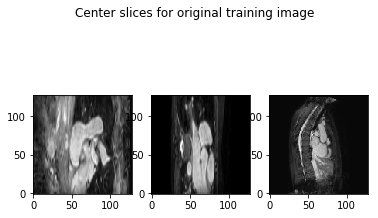

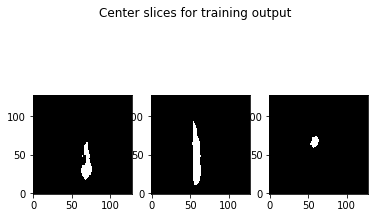

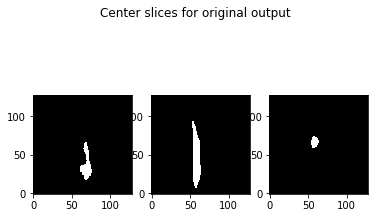

In [16]:
#Checking for train image
i=9
im = x_train[i].reshape(1,x_train[i].shape[0],x_train[i].shape[1],x_train[i].shape[2],x_train[i].shape[3])
n_im = x_train[i][0,:,:,:]
n_im = n_im.cpu()
n_im = n_im.detach().numpy()
slice_0 = n_im[64, :, :]
slice_1 = n_im[:, 64, :]
slice_2 = n_im[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original training image") 

# im = torch.from_numpy(im)
im = im.to(device)
im = im.float()
output = saved(im)
pred = F.softmax(output,1)
pred = pred[0,:,:,:]
pred = pred.cpu()
pred = pred.detach().numpy()
# print(pred.shape)
result = np.argmax(pred, axis = 0)
result = result.reshape(128, 128, 128)
slice_0 = result[64, :, :]
slice_1 = result[:, 64, :]
slice_2 = result[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for training output")

ori = y_train[i]
ori = ori.cpu()
ori = ori.detach().numpy()
slice_0 = ori[64, :, :]
slice_1 = ori[:, 64, :]
slice_2 = ori[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original output")

Text(0.5,0.98,'Center slices for original output')

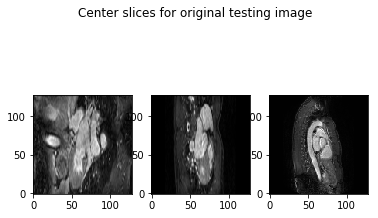

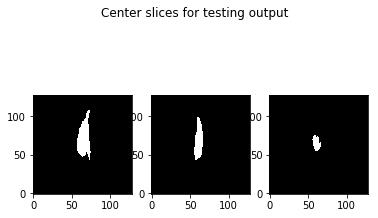

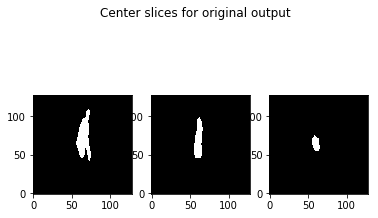

In [17]:
#Checking for test image
i=2
im = x_test[i].reshape(1,x_test[i].shape[0],x_test[i].shape[1],x_test[i].shape[2],x_test[i].shape[3])
n_im = x_test[i][0,:,:,:]
n_im = n_im.cpu()
n_im = n_im.detach().numpy()
slice_0 = n_im[64, :, :]
slice_1 = n_im[:, 64, :]
slice_2 = n_im[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original testing image") 

# im = torch.from_numpy(im)
im = im.to(device)
im = im.float()
output = saved(im)
pred = F.softmax(output,1)
pred = pred[0,:,:,:]
pred = pred.cpu()
pred = pred.detach().numpy()
# print(pred.shape)
result = np.argmax(pred, axis = 0)
result = result.reshape(128, 128, 128)
slice_0 = result[64, :, :]
slice_1 = result[:, 64, :]
slice_2 = result[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for testing output")

ori = y_test[i]
ori = ori.cpu()
ori = ori.detach().numpy()
slice_0 = ori[64, :, :]
slice_1 = ori[:, 64, :]
slice_2 = ori[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original output")